In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from cvxopt import solvers, matrix
from tqdm import tqdm 

## Class & Functions

In [3]:
R1 = np.array([[0,0,0,0,0,0,0,0,0,0], 
              [0,0,0,0,0,0,0,0,0,0], 
              [0,0,0,0,0,-10,-10,0,0,0], 
              [0,0,0,0,0,-10,-10,0,0,0],
              [0,-10,-10,0,0,0,0,0,0,0],
              [0,-10,-10,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0,0],
              [0,0,-10,-10,0,0,0,0,0,0],
              [0,0,-10,-10,0,0,0,0,0,1]])
R1 = R1.T.ravel()

R2 = np.array([[0,0,0,0,0,0,0,0,0,0], 
              [0,0,0,0,-100,-100,-100,0,0,0], 
              [0,0,0,0,-100,0,-100,0,0,0], 
              [0,0,0,0,-100,0,-100,-100,-100,0],
              [0,0,0,0,-100,0,0,0,-100,0],
              [0,0,0,0,-100,0,0,0,-100,0],
              [0,0,0,0,-100,0,0,0,-100,0],
              [0,0,0,0,0,0,-100,-100,-100,0],
              [0,0,0,0,0,0,-100,0,0,0],
              [0,0,0,0,0,0,0,0,0,10]])
R2 = R2.T.ravel()

In [4]:
## Define the gridworld MDP class

class Gridworld(object):
    """
    Gridworld MDP.
    """
    
    def __init__(self, grid_size, wind):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.tp = np.array(
            [[self._transition_probability(s, a)
               for s in range(self.n_states)]
              for a in range(self.n_actions)])

    def __str__(self):
        return "Gridworld({}, {})".format(self.grid_size, 
                                              self.wind)
    
    def int_to_point(self, s):
        """
        Convert a state int into the corresponding coordinate.

        s: State int.
        -> (x, y) int tuple.
        """

        return (s % self.grid_size, s // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def next_state(self, s, a):
        """
        Get next state if w=0.

        s: State int.
        a: Action int.
        -> State int.
        """
        xs, ys = self.int_to_point(s)
        xa, ya = self.actions[a]
        max = self.grid_size - 1

        if (xs + xa < 0) or (xs + xa > max) or (ys + ya < 0) or (ys + ya > max):
            return self.point_to_int((xs, ys))
        else:
            return self.point_to_int((xs + xa, ys + ya))

    def _transition_probability(self, s, a):
        """ 
        Get transition probability.

        s: State int.
        a: Action int.
        -> n_states long list. 
        """
        w = self.wind
        tp = np.zeros(self.n_states)

        for move in range(len(self.actions)):
            P = w / 4
            # intended moving direction
            if a == move:
                P += 1 - w
            # next state of this move, might be repetitive
            ns = self.next_state(s, move)
            tp[ns] += P

        return tp

In [5]:
## The value iteration algorithm to compute the optimal value function for each state

def value_iteration(gw, R, snap = 0, discount = 0.8, threshold = 0.01):
    """
    Find the optimal value function.

    gw: Gridworld object.
    -> V: Optimal state value
    -> pi: Optimal policy
    -> iter: Converging iterations
    """

    # Initialization
    P = gw.tp
    V = np.zeros(gw.n_states)
    policy = np.zeros(gw.n_states)
    delta = np.inf
    iter = 0
    gamma = discount
    epsilon = threshold
    
    # Esitimation
    while delta > epsilon:   
        delta = 0
        iter += 1
        for s in range(gw.n_states):
            v = V[s]
            V[s] = np.amax(np.matmul(P[:, s, :], (R + gamma * V)))
            delta = max(delta, abs(v - V[s]))
        # Plot snapshots
        if snap != 0:
            if iter % snap == 1:
                print('Iteration: ', str(iter))
                plot_matrix(np.transpose(V.reshape(10,10)), 'Optimal state values for step ' + str(iter))

    # Computation
    for s in range(gw.n_states):
        policy[s] = np.argmax(np.matmul(P[:, s, :], (R + gamma * V)))

    return V, policy.astype(int), iter

In [6]:
def plot_matrix(matrix, title='empty'):
    fig, ax = plt.subplots()
    num_rows = len(matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = matrix[i][j]
            ax.text(j + 0.5, i + 0.5, '{:.1f}'.format(c), va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    plt.title(title)
    plt.savefig('images/' + title.replace(" ","-") + '.png', dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
def plot_heatmap(matrix, title='empty'):
  plt.pcolor(matrix, edgecolors='black')
  plt.gca().invert_yaxis()
  plt.colorbar()
  plt.title(title)
  plt.savefig('images/' + title.replace(" ","-") + '.png', dpi=300, bbox_inches='tight')
  plt.show()

In [8]:
def plot_arrow(action_matrix, title='empty'):
    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'↓'
            elif(c == 1):
                arrow = u'→'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'←'
            
            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    plt.title(title)
    plt.savefig('images/' + title.replace(" ","-") + '.png', dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
## Creating the gridworld MDP with the following parameters
grid_size = 10
wind = 0.1

# Make the gridworld 
gw = Gridworld(grid_size, wind)

## Question 1-5

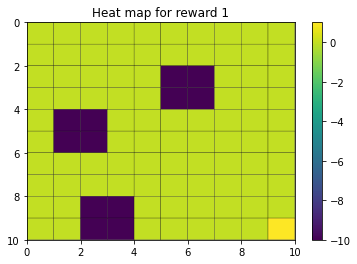

Iteration:  1


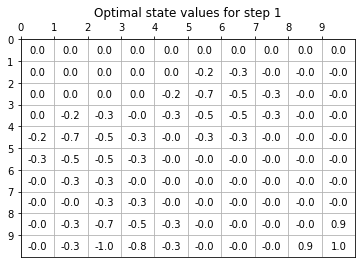

Iteration:  5


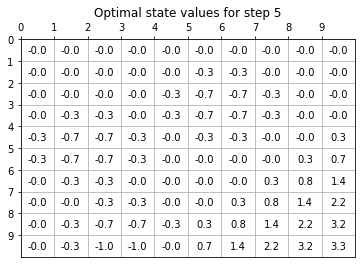

Iteration:  9


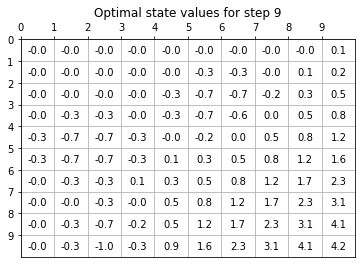

Iteration:  13


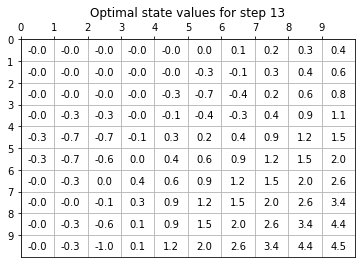

Iteration:  17


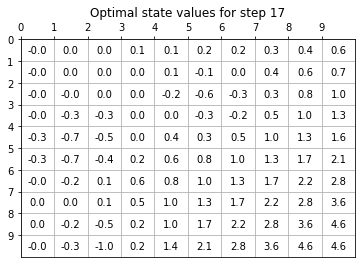

Iteration:  21


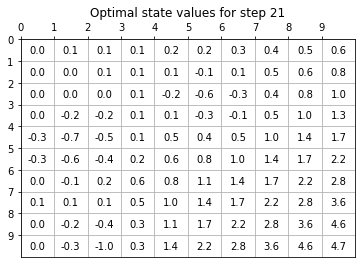

Total iteration:  21


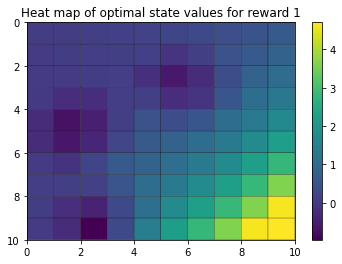

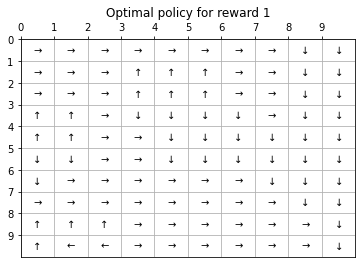

In [10]:
plot_heatmap(R1.reshape(10,10).T, 'Heat map for reward 1')
V1, policy1, N1 = value_iteration(gw, R1, 4)
print('Total iteration: ', str(N1))
plot_heatmap(V1.reshape(10,10).T, 'Heat map of optimal state values for reward 1')
plot_arrow(policy1.reshape(10,10).T, 'Optimal policy for reward 1')

In [11]:
print(policy1[89])

1


## Question 6-8

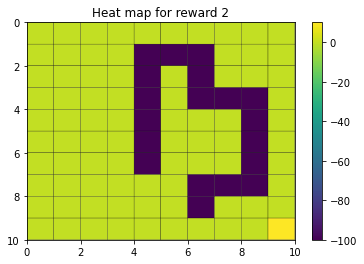

Total iteration:  31


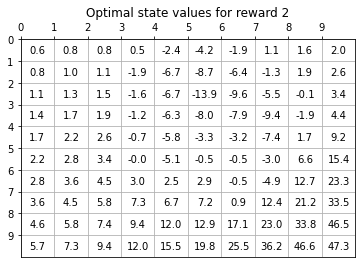

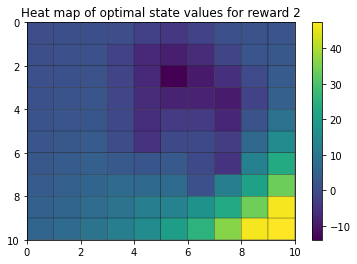

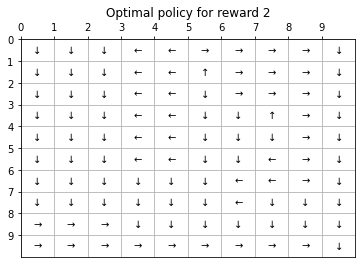

In [12]:
plot_heatmap(R2.reshape(10,10).T, 'Heat map for reward 2')
V2, policy2, N2 = value_iteration(gw, R2)
print('Total iteration: ', str(N2))
plot_matrix(V2.reshape(10,10).T, 'Optimal state values for reward 2')
plot_heatmap(V2.reshape(10,10).T, 'Heat map of optimal state values for reward 2')
plot_arrow(policy2.reshape(10,10).T, 'Optimal policy for reward 2')

## Question 9

In [18]:
## Creating the gridworld MDP with the following parameters
grid_size = 10
wind = 0.6

# Make the gridworld 
gw1 = Gridworld(grid_size, wind)

Total iteration:  16


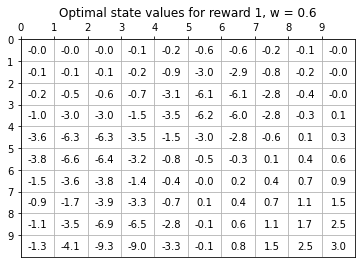

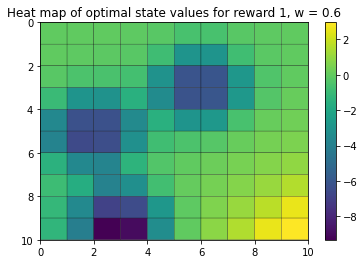

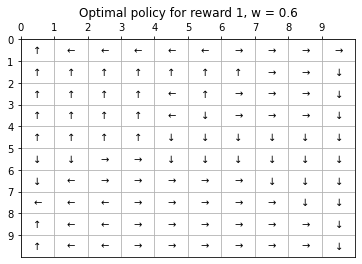

In [21]:
V3, policy3, N3 = value_iteration(gw1, R1)
print('Total iteration: ', str(N3))
plot_matrix(V3.reshape(10,10).T, 'Optimal state values for reward 1, w = 0.6')
plot_heatmap(V3.reshape(10,10).T, 'Heat map of optimal state values for reward 1, w = 0.6')
plot_arrow(policy3.reshape(10,10).T, 'Optimal policy for reward 1, w = 0.6')

Total iteration:  22


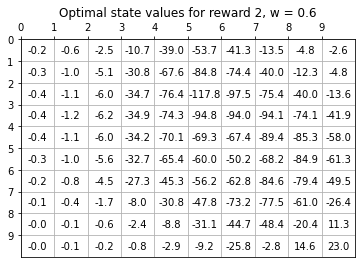

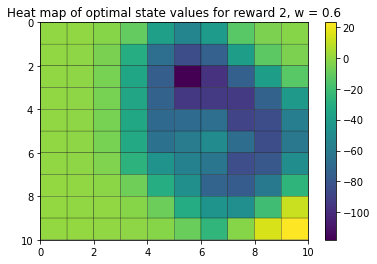

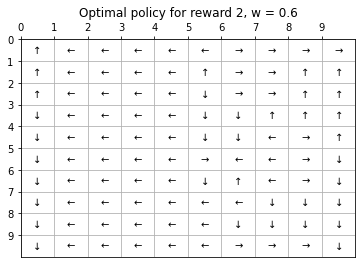

In [22]:
V4, policy4, N4 = value_iteration(gw1, R2)
print('Total iteration: ', str(N4))
plot_matrix(V4.reshape(10,10).T, 'Optimal state values for reward 2, w = 0.6')
plot_heatmap(V4.reshape(10,10).T, 'Heat map of optimal state values for reward 2, w = 0.6')
plot_arrow(policy4.reshape(10,10).T, 'Optimal policy for reward 2, w = 0.6')

## Question 10-12

In [23]:
def construct_lp_matrices(gw, policy, lmda, Rmax, gamma = 0.8):
    P = gw.tp
    S = gw.n_states
    nA = gw.n_actions
    c = np.concatenate([np.ones((S,)), -lmda * np.ones((S,)), np.zeros((S,))])
    b = np.concatenate([np.zeros((2 * (nA - 1) * S + 2 * S,)), Rmax * np.ones((2 * S,))])
    D = np.array([])
    Pa1 = np.zeros((S, S))
    Pas = np.zeros((3, S, S))
    I, Z = np.identity(S), np.zeros((S,S))
    
    for s in range(S):
        optA = policy[s]
        Pa1[s, :] = P[optA][s]
        otherA = np.setdiff1d(range(nA), optA)
        for i, a in enumerate(otherA):
            Pas[i, s, :] = P[a][s]
            
    for i in range(nA - 1):
        Pa = Pas[i]
        temp = np.hstack((I, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma * Pa1))))
        temp = np.vstack((temp, np.hstack((Z, Z, np.matmul(Pa - Pa1, np.linalg.inv(I - gamma * Pa1))))))
        D = temp if (D.shape[0] == 0) else np.vstack((temp, D))
            
    D = np.vstack((D, np.hstack((Z, -I, I))))
    D = np.vstack((D, np.hstack((Z, -I, -I))))
    D = np.vstack((D, np.hstack((Z, Z, I))))
    D = np.vstack((D, np.hstack((Z, Z, -I))))
    
    return c, b, D

In [24]:
def solve_lp(gw, policy, lmda, Rmax):
    solvers.options['show_progress']=False
    c, b, D = construct_lp_matrices(gw, policy, lmda, Rmax)
    solution = solvers.lp(-matrix(c.transpose()), matrix(D), matrix(b))
    return np.array(solution['x'][-100:]).squeeze()

In [25]:
def calc_accuracy(gw, policy, lmdas, Rmax):
    accuracy = np.zeros_like(lmdas)
    for i, lmda in enumerate(tqdm(lmdas)):
        R_predicted = solve_lp(gw, policy, lmda, Rmax)
        V, policy_predicted, iter = value_iteration(gw, R_predicted)
        accuracy[i] = (policy_predicted == policy).sum() / gw.n_states
    return accuracy

500


100%|██████████| 500/500 [09:16<00:00,  1.11s/it]


Text(0.5, 0, '$\\lambda$')

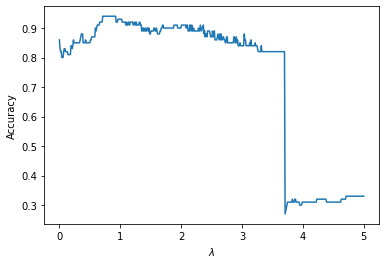

In [26]:
R1max = np.amax(np.abs(R1)) 
lmdas = np.linspace(0, 5, 500)
print(lmdas.size)
accuracy1 = calc_accuracy(gw, policy1, lmdas, R1max)
plt.title('Accuracy of IRL algorithm for reward 1')
plt.plot(lmdas, accuracy1)
plt.ylabel('Accuracy')
plt.xlabel('$\lambda$')
#plt.savefig('q11.png', bbox_inches='tight')

In [27]:
lmda_max1=lmdas[np.argmax(accuracy1)]
print(lmda_max1)

0.7114228456913827
